# FZD5
[microphthalmia/coloboma-11 (MCOPCB11)](https://omim.org/entry/620731) is caused by heterozygous mutation in the FZD5 gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.4


### FZD5
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for FZD5.

In [2]:
gene_symbol = 'FZD5'
mane_tx_id = 'NM_003468.4'
mane_protein_id = 'NP_065979.1' # zinc finger SWIM domain-containing protein 6

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.24') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)

qc_results.summarize()

Individuals Processed: 100%|██████████| 29/29 [00:00<00:00, 1755.98 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
16,Iris coloboma
9,Nystagmus
7,Chorioretinal coloboma
7,Retinal coloboma
7,Optic disc hypoplasia
7,Reduced visual acuity
5,Optic disc coloboma
5,High myopia
3,High hypermetropia
2,Microphthalmia


ValueError: zero-size array to reduction operation maximum which has no identity

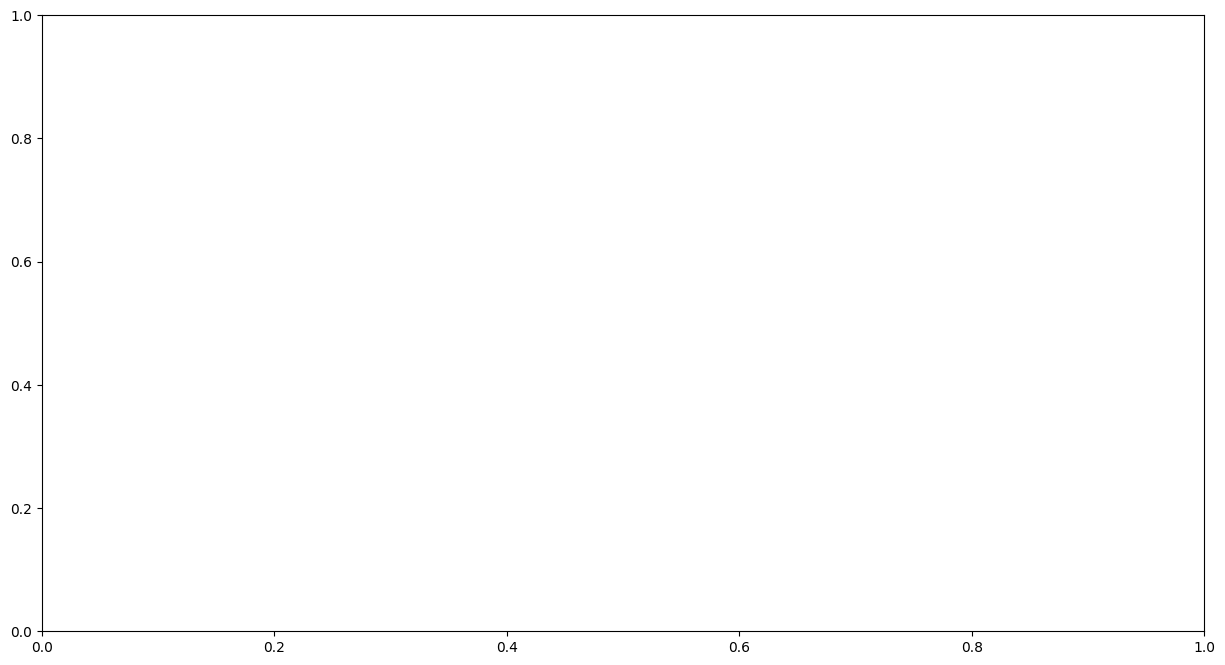

In [11]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
from gpsea.preprocessing import configure_default_protein_metadata_service

pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)
fzd5_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
fzd5_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

In [5]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [6]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.view import MtcStatsViewer

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = monoallelic_classifier(a_predicate=missense, 
                                           b_predicate=~missense, 
                                           a_label="missense", 
                                           b_label="other")
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,9
HMF08,Skipping general term,15
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,23


In [7]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,missense,other,Corrected p values,p values
Iris coloboma [HP:0000612],4/13 (31%),12/16 (75%),0.297588,0.027053
Retinal coloboma [HP:0000480],2/8 (25%),5/6 (83%),0.564103,0.102564
Optic disc coloboma [HP:0000588],0/3 (0%),5/9 (56%),0.750000,0.204545
Optic disc hypoplasia [HP:0007766],5/8 (62%),2/6 (33%),1.000000,0.592075
Abnormal fundus morphology [HP:0001098],10/10 (100%),15/15 (100%),1.000000,1.000000
Chorioretinal coloboma [HP:0000567],2/3 (67%),5/9 (56%),1.000000,1.000000
Abnormality iris morphology [HP:0000525],4/4 (100%),12/12 (100%),1.000000,1.000000
Reduced visual acuity [HP:0007663],4/8 (50%),3/6 (50%),1.000000,1.000000
Abnormal retinal morphology [HP:0000479],5/5 (100%),10/10 (100%),1.000000,1.000000
Coloboma [HP:0000589],5/5 (100%),14/14 (100%),1.000000,1.000000


# Summary

In [8]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
)

caption = "No significant correlations identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [9]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
missense,other,11,0


In [ ]:
summarizer.process_latex(report=report, protein_fig=fzd5_fig)